# Modelo de regresión y simulación
Ecuaciones usadas: $\tfrac{dS}{dt}=\xi_{1}M(t)+\xi_{2}E(t)-\xi_{3}S(t)+c_s$ y $\tfrac{dE}{dt}=\xi_{4}M(t)+\xi_{5}S(t)-\xi_{6}E(t)+c_e$. Primero se ajustan los coeficientes con regresión (incluyendo intercepto) y luego se simula con Runge-Kutta 4.


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

data_dir = Path('../../data/processed/salud')

# Datos de gasto en salud (S) y su derivada (dS/dt)
salud = pd.read_csv(data_dir / 'unified.csv')
salud = salud.rename(columns={'Año': 'anio', 'USD mex': 'S', 'dG/dt (mex)': 'dS_dt'})
salud = salud.drop(columns=[c for c in salud.columns if 'Unnamed' in c], errors='ignore')

# Datos de egresos hospitalarios (E)
egresos_path = next(data_dir.glob('Egresos_M*ico.csv'))
egresos = pd.read_csv(egresos_path).rename(columns={'Año': 'anio', 'Egresos': 'E'})
egresos['anio'] = egresos['anio'].astype(int)

df = salud.merge(egresos, on='anio', how='left')
df['dE_dt'] = df['E'].diff().fillna(0)

# Población adulta mayor (M) para usarla como fuerza exógena
pob = pd.read_csv('../../data/processed/poblaciones/mexico.csv')
pob = pob.rename(columns={'ANIO': 'anio', 'Poblacion adultos mayores (65+)': 'M'})
df = df.merge(pob[['anio', 'M']], on='anio', how='left')

for col in ['S', 'dS_dt', 'E', 'dE_dt', 'M']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.sort_values('anio').dropna(subset=['S', 'dS_dt', 'E', 'dE_dt', 'M']).reset_index(drop=True)
df.head()


,anio,S,USD ch,dS_dt,dG/dt (ch),E,dE_dt,M
0,2004,3.437250e+10,6.493000e+09,0.000000e+00,0.000000e+00,4416313,0.0,5761262.0
1,2005,3.443720e+10,6.944000e+09,6.470000e+07,4.510000e+08,4539477,123164.0,5953231.0
2,2006,3.845950e+10,8.485000e+09,4.022300e+09,1.541000e+09,4658305,118828.0,6155725.0
3,2007,4.166450e+10,9.633000e+09,3.205000e+09,1.148000e+09,4922227,263922.0,6368873.0
4,2008,4.561570e+10,1.063700e+10,3.951200e+09,1.004000e+09,5123675,201448.0,6585485.0


In [ ]:
# Regresión para dS/dt: dS = xi1*M + xi2*E - xi3*S + c_s
X_s = sm.add_constant(df[['M', 'E', 'S']], prepend=False)
y_s = df['dS_dt']
modelo_s = sm.OLS(y_s, X_s).fit()
coef_s = modelo_s.params
xi1, xi2, xi3 = coef_s['M'], coef_s['E'], -coef_s['S']
c_s = coef_s['const']

# Regresión para dE/dt: dE = xi4*M + xi5*S - xi6*E + c_e
X_e = sm.add_constant(df[['M', 'S', 'E']], prepend=False)
y_e = df['dE_dt']
modelo_e = sm.OLS(y_e, X_e).fit()
coef_e = modelo_e.params
xi4, xi5, xi6 = coef_e['M'], coef_e['S'], -coef_e['E']
c_e = coef_e['const']

print('Coeficientes salud (dS/dt = xi1*M + xi2*E - xi3*S + c_s)')
print({'xi1': xi1, 'xi2': xi2, 'xi3': xi3, 'c_s': c_s})
print('Coeficientes egresos (dE/dt = xi4*M + xi5*S - xi6*E + c_e)')
print({'xi4': xi4, 'xi5': xi5, 'xi6': xi6, 'c_e': c_e})

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

pred_s = modelo_s.predict(X_s)
pred_e = modelo_e.predict(X_e)
print('RMSE dS/dt:', rmse(y_s, pred_s))
print('RMSE dE/dt:', rmse(y_e, pred_e))


Coeficientes salud (dS/dt = xi1*M + xi2*E - xi3*S + c_s)
{'xi1': np.float64(-6531.9826570830255), 'xi2': np.float64(-2544.4291994731248), 'xi3': np.float64(-0.6793512347970985), 'c_s': np.float64(27857413633.08787)}
Coeficientes egresos (dE/dt = xi4*M + xi5*S - xi6*E + c_e)
{'xi4': np.float64(-0.16735097571020283), 'xi5': np.float64(7.758205814248898e-06), 'xi6': np.float64(-0.35337971671367563), 'c_e': np.float64(-919523.0911741722)}
RMSE dS/dt: 2181489228.6110334
RMSE dE/dt: 375611.20366309484


In [ ]:
# Definición del sistema y resolución con RK4 (incluyendo interceptos)
t_years = df['anio'].to_numpy()
t0 = t_years.min()
M_series = df['M'].to_numpy()

def M_trend(t):
    # t se mide en años desde t0
    return np.interp(t + t0, t_years, M_series)

def sistema_edos(t, y):
    S, E = y
    Mt = M_trend(t)
    dS = xi1 * Mt + xi2 * E - xi3 * S + c_s
    dE = -xi4 * Mt + xi5 * S - xi6 * E + c_e
    return np.array([dS, dE], dtype=float)

def rk4(func, y0, t0_local, tf_local, h=0.1):
    t_vals = np.arange(t0_local, tf_local + h, h)
    y_vals = np.zeros((len(t_vals), len(y0)))
    y_vals[0] = y0
    for i in range(1, len(t_vals)):
        t_prev = t_vals[i - 1]
        y_prev = y_vals[i - 1]
        k1 = func(t_prev, y_prev)
        k2 = func(t_prev + h / 2, y_prev + h * k1 / 2)
        k3 = func(t_prev + h / 2, y_prev + h * k2 / 2)
        k4 = func(t_prev + h, y_prev + h * k3)
        y_vals[i] = y_prev + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return t_vals, y_vals

y0 = np.array([df.iloc[0]['S'], df.iloc[0]['E']], dtype=float)
t_vals, y_vals = rk4(sistema_edos, y0=y0, t0_local=0, tf_local=10, h=0.1)
sim_years = t_vals + t0
sim_S, sim_E = y_vals[:, 0], y_vals[:, 1]


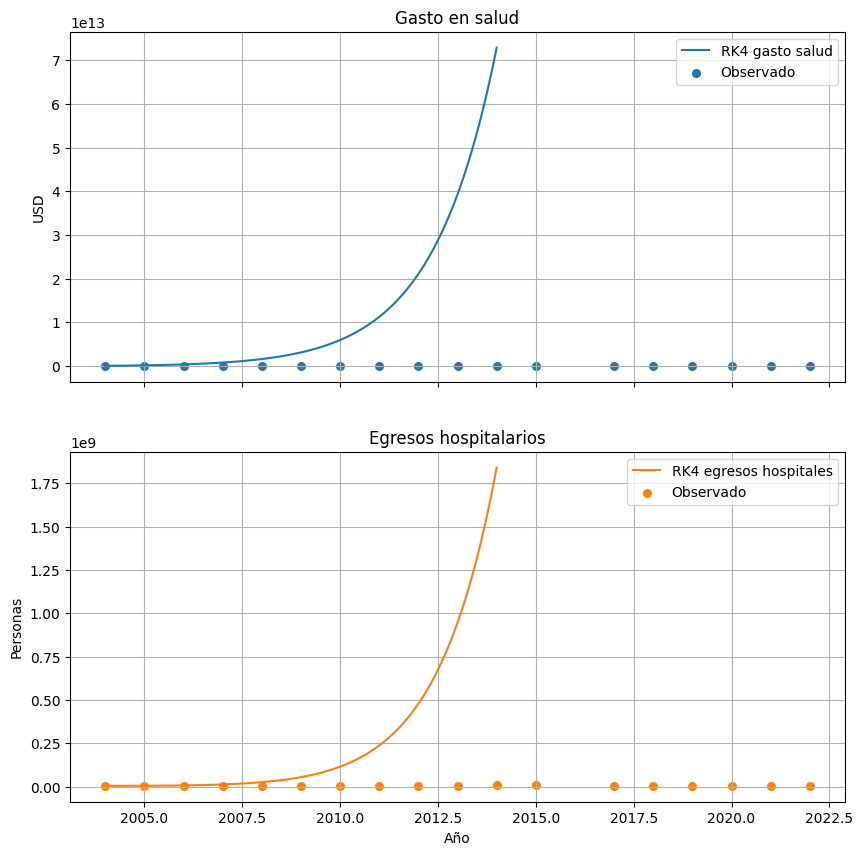

In [ ]:
# Gráficas comparando simulación vs datos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax1.plot(sim_years, sim_S, label='RK4 gasto salud', color='C0')
ax1.scatter(df['anio'], df['S'], color='C0', marker='o', s=30, label='Observado')
ax1.set_ylabel('USD')
ax1.set_title('Gasto en salud')
ax1.grid(True)
ax1.legend()

ax2.plot(sim_years, sim_E, label='RK4 egresos hospitales', color='C1')
ax2.scatter(df['anio'], df['E'], color='C1', marker='o', s=30, label='Observado')
ax2.set_xlabel('Año')
ax2.set_ylabel('Personas')
ax2.set_title('Egresos hospitalarios')
ax2.grid(True)
ax2.legend()

plt.show()


In [ ]:
# Resumenes de los modelos por si se quieren revisar
display(modelo_s.summary())
display(modelo_e.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dS_dt   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     7.628
Date:                Thu, 27 Nov 2025   Prob (F-statistic):            0.00291
Time:                        09:41:08   Log-Likelihood:                -412.60
No. Observations:                  18   AIC:                             833.2
Df Residuals:                      14   BIC:                             836.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M          -6531.9827   1923.403     -3.396      0.004   -1.07e+04   -2406.693
E          -2544.4292   1086.646     -2.342      0.035   -4875.054    -213.805
S              0.6794      0.169      4.027      0.001       0.318       1.041
const       2.786e+10   8.03e+09      3.469      0.004    1.06e+10    4.51e+10
==============================================================================
Omnibus:                        2.072   Durbin-Watson:                   2.352
Prob(Omnibus):                  0.355   Jarque-Bera (JB):                1.358
Skew:                          -0.665   Prob(JB):                        0.507
Kurtosis:                       2.798   Cond. No.                     8.50e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dE_dt   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1.389
Date:                Thu, 27 Nov 2025   Prob (F-statistic):              0.287
Time:                        09:41:08   Log-Likelihood:                -256.59
No. Observations:                  18   AIC:                             521.2
Df Residuals:                      14   BIC:                             524.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M             -0.1674      0.331     -0.505      0.621      -0.878       0.543
S           7.758e-06    2.9e-05      0.267      0.793   -5.45e-05    7.01e-05
E              0.3534      0.187      1.889      0.080      -0.048       0.755
const      -9.195e+05   1.38e+06     -0.665      0.517   -3.89e+06    2.05e+06
==============================================================================
Omnibus:                        5.175   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                2.801
Skew:                          -0.583   Prob(JB):                        0.247
Kurtosis:                       4.542   Cond. No.                     8.50e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""